# ESM Temperature profile mask
The purpose of this notebook is to create a mask to remove all land based data points for the ESM3 temperature data from historic simulations. To do this the notebook takes information from the Volcello data sets.

The [mask calculation and creation](#Calculating-the-mask) can be found in the bottom half of the document.

#### Dask Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38293")
client

Client Scheduler: tcp://127.0.0.1:38293 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 25.77 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Ocean Area data for averaging
areaActivityId = 'CMIP'
areaVariableId = 'volcello'
areaSourceId = 'E3SM-1-0'
areaDataSetNo = 0 #First database in results to be used

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
levSel = 5.0

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
from math import isnan
print("Imports complete")

Imports complete


<br>

#### Accessing Dataset Database

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print("Database accessed")

Database accessed


<br>

#### Filtering for relevant data sets
ESM3 data sets

In [5]:
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]
print(str(len(dfFilt))+" datasets found.")
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
270973,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
271590,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401412,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401422,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
430635,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


<br>
Ocean area data to be used for averaging

In [6]:
dfArea = df[df.activity_id.eq(areaActivityId) & df.variable_id.eq(areaVariableId) & df.source_id.eq(areaSourceId)]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

4 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
502770,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210127
502774,CMIP,E3SM-Project,E3SM-1-0,piControl,r1i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/pi...,NaN,20210127
502778,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210128
502780,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,volcello,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20210128


<br>

#### Opening all datafiles
ESM3 data

In [7]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" ESM3 data sets opened")
else:
    print("No ESM3 data sets opened")

5 ESM3 data sets opened


Ocean Area data

In [8]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[areaDataSetNo]), consolidated=True)
print("Ocean Area data loaded")

Ocean Area data loaded


<br>

#### Combine data sets into one xarray

In [9]:
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunID') #Combining data sets
print("Data sets successfully merged")
#fileSet #Uncomment to see full data set

Data sets successfully merged


<br>

#### Selection of Data

In [10]:
dataFiltLat = fileSet.thetao.sel(lat=latSel) #Selection of latitude
#dataFiltLatLev = fileSet.thetao.sel(lev=levSel) #Selection of depth
dataFiltFull = dataFiltLat.reset_coords(drop=True) #Removes lev if single value

dataAreaFilt = dsArea.volcello.sel(lat=latSel)
dataAreaFilt = dataAreaFilt.reset_coords(drop=True)

print("Finished data selection")
#dataFiltFull #Uncomment to see filtered data set

Finished data selection


<br>

#### Time identification

In [11]:
globalStartDate = dataFiltFull["time"][0].values
globalDateInc = dataFiltFull["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dataFiltFull["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("Data start date: "+globalStartDateStr)
print("Data end date (included): "+str(globalEndDateInStr))
print("Data end date (excluded): "+str(globalEndDateOutStr))
print("Data increments in steps of "+str(globalDateInc))

Data start date: 1850-01
Data end date (included): 2014-12
Data end date (excluded): 2015-01
Data increments in steps of 2678400000000000 nanoseconds


<br>

#### Calculation
<b>Functions:</b><br>
convertToOne - Takes an input data set and returns a same dimensioned data set with values (int) 1 for all non Nan values (maximum input value magnitude 10^14). Is a delayed type.<br>
maskCalc - takes an input data set and returns a (int) 1 and "Nan" mask.<br>

In [12]:
@delayed
def convertToOne(dataSet):
    '''Takes in given dataSet and returns values of (int) 1 for all non Nan values (10^14 max value)'''
    dataSetModify = dataSet.copy()
    dataSetModify.values = dataSetModify.values/100000000000000 + 1
    dataSetModify = dataSetModify.astype(int)
    return dataSetModify


def maskCalc(LocData, plotNo):
    '''Takes in a given data set and returns a data set of (int) 1 and Nan matching initial data set.'''
    mask = convertToOne(LocData)
    mask = mask.compute()
    maskNan = mask.where(mask.values == 1)
    return maskNan

print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting functions
<b>Functions</b> <br>
mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number <br>

In [13]:
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))

print("Plotting functions defined")

Plotting functions defined


<br>

#### Calculating the mask

<b>Creating the mask</b><br>
Selecting the relevant surface data

In [14]:
maskData = dataAreaFilt.copy()
maskData = maskData.sel(lev=5.0)
maskData = maskData.mean('time')
maskData = maskData.reset_coords(drop=True)
print("Surface data selected")

Surface data selected


<br>
<b>Calculating the mask</b><br>

In [15]:
oceanMask = maskCalc(maskData, 1)
print("Ocean mask calculated")

Ocean mask calculated


<br>
<b>Plotting volcello data and the created mask</b><br>

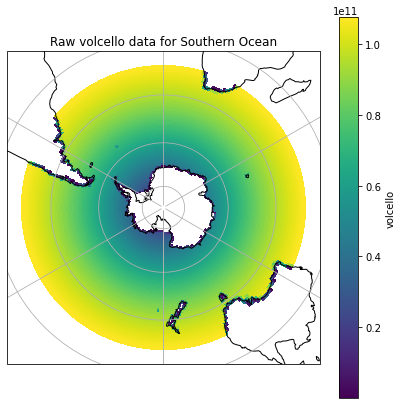

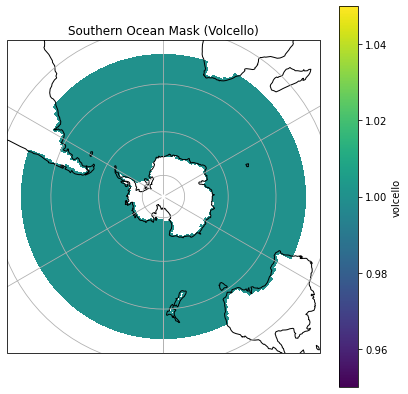

In [16]:
mapPlot(maskData, "Raw volcello data for Southern Ocean", 1)
mapPlot(oceanMask, "Southern Ocean Mask (Volcello)", 2)

<br>

#### Saving and reloading the mask
<b>Saving the mask</b><br>

In [17]:
maskName = "OceanMaskVolcello3"
oceanMask.to_netcdf(maskName)
print("Mask saved")

Mask saved


<br>
<b>Reloading the mask</b><br>

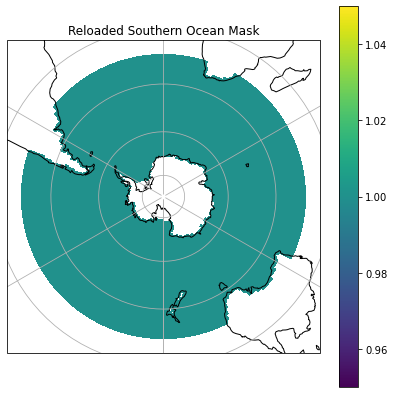

In [18]:
maskFile = xr.open_dataset(maskName)
oceanMaskReload = maskFile.to_array()
mapPlot(oceanMaskReload, "Reloaded Southern Ocean Mask", 1)

<br>
<b>Testing</b><br>

In [19]:
testLoc = [[-32.5,(360-60.5),float("Nan")], [-32.5,22.5,float("Nan")],[-41.5,5.5,1.0]]
print("ESM3   Volcello   Mask   Loaded Mask   Expected")
passedM = True
passedMR = True
for i in range(len(testLoc)):
    temp = dataFiltFull.sel(lat=testLoc[i][0], lon=testLoc[i][1], time='2004-01', RunID=1, lev=5.0)
    temp2 = dataAreaFilt.sel(lat=testLoc[i][0], lon=testLoc[i][1], time='2004-01', lev=5.0)
    temp3 = oceanMask.sel(lat=testLoc[i][0], lon=testLoc[i][1])
    temp4 = oceanMaskReload.sel(lat=testLoc[i][0], lon=testLoc[i][1])
    if temp3.values != testLoc[i][2]:
        if not(isnan(temp3.values) and isnan(testLoc[i][2])):
            passedM = False
    if temp4.values[0] != testLoc[i][2]:
        if not(isnan(temp4.values[0]) and isnan(testLoc[i][2])):
            passedMr = False
    print(np.round(temp.values[0], 2),"\t",  f'{temp2.values[0]: .3}', "\t", temp3.values, "\t", temp4.values[0], "\t", testLoc[i][2])
print("Mask passed: ", passedM)
print("Loaded mask passed: ", passedMR)

ESM3   Volcello   Mask   Loaded Mask   Expected
1.0 	  nan 	 nan 	 nan 	 nan
1.0 	  nan 	 nan 	 nan 	 nan
13.62 	  9.26e+10 	 1.0 	 1.0 	 1.0
Mask passed:  True
Loaded mask passed:  True


<br>